# Coauthorship Graph Creation

This notebook constructs coauthorship graphs from the Brazilian Lattes academic network.
Nodes represent researchers; edges represent coauthorship in books, chapters, events, or journals.

In [98]:
import pandas as pd
import unidecode
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm

## Utility Functions

These functions are used throughout the notebook for data reading, string standardization, and clustering by year.

In [99]:
def read_dataset(data_dir: str, scope: str, dataset: str) -> pd.DataFrame:
    """
    Read a CSV dataset from the processed data directory.
    """
    path = f"{data_dir}processed/{scope}/{dataset}.csv"
    return pd.read_csv(path)

In [100]:
def standardize_string(text: str) -> str:
    """
    Convert text to lowercase and remove diacritics.
    """
    return unidecode.unidecode(text.lower()) if isinstance(text, str) else ""

In [101]:
def cluster_by_year(df: pd.DataFrame, year_col: str) -> pd.Series:
    """
    Cluster rows by consecutive years within a difference of 1 year.
    Returns a series of cluster labels aligned with df.index.
    """
    df_sorted = df.sort_values(year_col)
    clusters = pd.Series(index=df_sorted.index, dtype=int)
    next_cluster = 0
    prev_year = None
    for idx, year in zip(df_sorted.index, df_sorted[year_col].astype(int)):
        if prev_year is None or year - prev_year > 1:
            next_cluster += 1
        clusters.at[idx] = next_cluster
        prev_year = year
    return clusters

## Data Loading

In [102]:
DATA_DIR = "../data/"
scope = "aplicacoes"

df_book = read_dataset(DATA_DIR, scope, "livros")
df_user = read_dataset(DATA_DIR, scope, "gerais")
df_per = read_dataset(DATA_DIR, scope, "periodicos")
df_cap = read_dataset(DATA_DIR, scope, "capitulos")
df_eventos = read_dataset(DATA_DIR, scope, "eventos")

/var/folders/b4/g00rwnnd2qg3f0fvnnt5wwjw0000gn/T/ipykernel_6932/3706680162.py:6: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


## Data Inspection

View basic shapes to confirm successful loading.

In [103]:
print("Shapes:")
print(f"  gerais:     {df_user.shape}")
print(f"  livros:     {df_book.shape}")
print(f"  periodicos: {df_per.shape}")
print(f"  capitulos:  {df_cap.shape}")
print(f"  eventos:    {df_eventos.shape}")

Shapes:
  gerais:     (3992, 9)
  livros:     (8119, 26)
  periodicos: (169425, 19)
  capitulos:  (27645, 26)
  eventos:    (328035, 19)


## Prepare Data: Assign Coauthorship IDs

We assign unique IDs for each work based on your rules:
- Books: ISBN OR (title AND year)
- Periodicals: DOI OR (ISSN AND title AND year)
- Chapters: (ISBN OR book title) AND (chapter title AND year)
- Events: DOI OR (title + year)

After assignment, we drop records without an assigned ID.

### Removing the character ' from LattesID on both CSVs

In [104]:
df_book.LattesID = df_book.LattesID.apply(lambda x: x[1:])
df_cap.LATTES_ID = df_cap.LATTES_ID.apply(lambda x: x[1:]) 

### Initialize ID Counter

In [105]:
_next = 0  # Global counter for assigning unique work IDs

### Books Coauthorship IDs

In [106]:
# Standardize columns
df_book["isbn_std"] = df_book["ISBN"].astype(str).apply(standardize_string).replace({"nan": None})
df_book["title_std"] = df_book["TITULO-DO-LIVRO"].apply(standardize_string)
df_book["year_int"] = pd.to_numeric(df_book["ANO"], errors="coerce")

# Initialize ID column
df_book["book_id"] = None

# Layer 1: ISBN matching
mask1 = df_book["isbn_std"].notna() & (df_book["isbn_std"] != "")
for isbn, grp in df_book[mask1].groupby("isbn_std"):
    _next += 1
    df_book.loc[grp.index, "book_id"] = _next

# Layer 2: Title + year ±1
mask2 = df_book["book_id"].isna() & df_book["year_int"].notna()
for title, grp in df_book[mask2].groupby("title_std"):
    clusters = cluster_by_year(grp, "year_int")
    for cid in clusters.unique():
        _next += 1
        idxs = clusters[clusters == cid].index
        df_book.loc[idxs, "book_id"] = _next

# Drop books without ID
df_book = df_book[df_book["book_id"].notna()]

# Create user-book mapping
df_user_book = df_book[["LattesID", "book_id"]].copy()

### Periodicals Coauthorship IDs

In [107]:
df_per["doi_std"] = df_per["DOI"].astype(str).apply(standardize_string).replace({"nan": None})
df_per["issn_std"] = df_per["ISSN"].astype(str).apply(standardize_string).replace({"nan": None})
df_per["title_std"] = df_per["TITULO-DO-ARTIGO"].apply(standardize_string)
df_per["year_int"] = pd.to_numeric(df_per["ANO-DO-ARTIGO"], errors="coerce")

df_per["paper_id"] = None

# Layer 1: DOI matching
mask1 = df_per["doi_std"].notna() & (df_per["doi_std"] != "")
for doi, grp in df_per[mask1].groupby("doi_std"):
    _next += 1
    df_per.loc[grp.index, "paper_id"] = _next

# Layer 2: ISSN + title + year ±1
mask2 = df_per["paper_id"].isna() & df_per["year_int"].notna()
for (issn, title), grp in df_per[mask2].groupby(["issn_std", "title_std"]):
    clusters = cluster_by_year(grp, "year_int")
    for cid in clusters.unique():
        _next += 1
        idxs = clusters[clusters == cid].index
        df_per.loc[idxs, "paper_id"] = _next

# Drop periodicals without ID
df_per = df_per[df_per["paper_id"].notna()]

df_user_per = df_per[["LattesID", "paper_id"]].copy()

### Chapters Coauthorship IDs

In [108]:
df_cap["isbn_std"] = df_cap["ISBN"].astype(str).apply(standardize_string).replace({"nan": None})
df_cap["book_std"] = df_cap["TITULO-DO-LIVRO"].apply(standardize_string)
df_cap["chap_std"] = df_cap["TITULO-DO-CAPITULO-DO-LIVRO"].apply(standardize_string)
df_cap["year_int"] = pd.to_numeric(df_cap["ANO"], errors="coerce")

df_cap["chapter_id"] = None

# Single layer: (ISBN or book title) + chapter title + year ±1
mask1 = ((df_cap["isbn_std"].notna() & (df_cap["isbn_std"] != "")) | (df_cap["book_std"] != ""))         & df_cap["year_int"].notna()
for (isbn, book, chap), grp in df_cap[mask1].groupby(["isbn_std", "book_std", "chap_std"]):
    clusters = cluster_by_year(grp, "year_int")
    for cid in clusters.unique():
        _next += 1
        idxs = clusters[clusters == cid].index
        df_cap.loc[idxs, "chapter_id"] = _next

# Drop chapters without ID
df_cap = df_cap[df_cap["chapter_id"].notna()]

df_user_cap = df_cap[["LATTES_ID", "chapter_id"]].rename(columns={'LATTES_ID':'LattesID'}).copy()

### Events Coauthorship IDs

In [109]:
df_eventos["doi_std"] = df_eventos["DOI"].astype(str).apply(standardize_string).replace({"nan": None})
df_eventos["title_std"] = df_eventos["TITULO-DO-TRABALHO"].apply(standardize_string)
df_eventos["year_int"] = pd.to_numeric(df_eventos["ANO-DO-TRABALHO"], errors="coerce")

df_eventos["paper_id"] = None

# Layer 1: DOI matching
mask1 = df_eventos["doi_std"].notna() & (df_eventos["doi_std"] != "")
for doi, grp in df_eventos[mask1].groupby("doi_std"):
    _next += 1
    df_eventos.loc[grp.index, "paper_id"] = _next

# Layer 2: title + year ±1
mask2 = df_eventos["paper_id"].isna() & df_eventos["year_int"].notna()
for title, grp in df_eventos[mask2].groupby("title_std"):
    clusters = cluster_by_year(grp, "year_int")
    for cid in clusters.unique():
        _next += 1
        idxs = clusters[clusters == cid].index
        df_eventos.loc[idxs, "paper_id"] = _next

# Drop events without ID
df_eventos = df_eventos[df_eventos["paper_id"].notna()]

df_user_eventos = df_eventos[["LattesID", "paper_id"]].copy()

## Build Combined Coauthorship DataFrame

In [110]:
# Tag work IDs and combine all datasets
df_user_book["work_id"] = df_user_book["book_id"].astype(str).apply(lambda x: f"livros_{x}")
df_user_per["work_id"] = df_user_per["paper_id"].astype(str).apply(lambda x: f"periodicos_{x}")
df_user_cap["work_id"] = df_user_cap["chapter_id"].astype(str).apply(lambda x: f"capitulos_{x}")
df_user_eventos["work_id"] = df_user_eventos["paper_id"].astype(str).apply(lambda x: f"eventos_{x}")

# Prefix LattesID uniformly
for df in [df_user_book, df_user_per, df_user_cap, df_user_eventos]:
    df["LattesID"] = df["LattesID"].apply(lambda x: f"LattesID_{x}")

# Concatenate and drop duplicates
df_co = pd.concat([df_user_book[["LattesID", "work_id"]],
                   df_user_per[["LattesID", "work_id"]],
                   df_user_cap[["LattesID", "work_id"]],
                   df_user_eventos[["LattesID", "work_id"]]],
                  ignore_index=True)
df_co.drop_duplicates(inplace=True)

# Filter only researchers present in gerais
valid_ids = set(df_user["LattesID"].apply(lambda x: f"LattesID_{x}"))
df_co = df_co[df_co["LattesID"].isin(valid_ids)]

## Create and Save Graphs

In [111]:
def create_and_save_graph(df: pd.DataFrame, set_type: str) -> nx.Graph:
    """
    Build a weighted coauthorship graph and save edge list and GEXF file.
    """
    pairs = []
    for work_id, group in tqdm(df.groupby("work_id"), total=df["work_id"].nunique()):
        users = list(group["LattesID"])
        if len(users) > 1:
            pairs.extend(combinations(users, 2))

    coauthor_df = pd.DataFrame(pairs, columns=["author1", "author2"])
    coauthor_weighted = coauthor_df.assign(count=1).groupby(["author1", "author2"]).sum().reset_index()

    coauthor_weighted.to_csv(
        f"../data/processed/{scope}/graphs_weights/{set_type}_weighted.csv", index=False
    )

    G = nx.Graph()
    for _, row in coauthor_weighted.iterrows():
        G.add_edge(row["author1"], row["author2"], weight=row["count"])

    nx.write_gexf(G, f"../graphs/{scope}/{set_type}_graph.gexf")
    return G

In [112]:
G_book = create_and_save_graph(df_user_book, "livros")
G_per = create_and_save_graph(df_user_per, "periodicos")
G_cap = create_and_save_graph(df_user_cap, "capitulos")
G_evt = create_and_save_graph(df_user_eventos, "eventos")
G_co  = create_and_save_graph(df_co, "coauthorship")

100%|██████████| 465437/465437 [00:06<00:00, 71150.62it/s]


## Visualize Coauthorship Graph

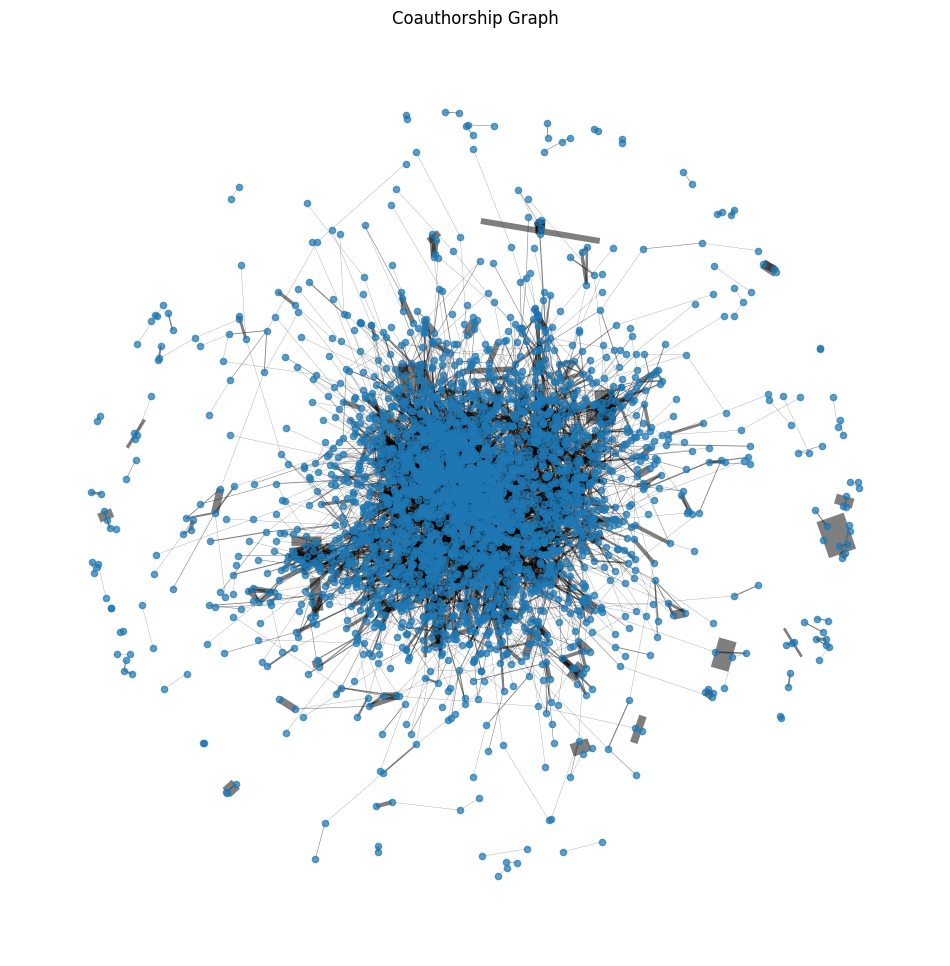

In [113]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_co, k=0.1, seed=42)
edges = [(u, v) for u, v, d in G_co.edges(data=True)]
weights = [G_co[u][v]["weight"] for u, v in edges]
nx.draw_networkx_nodes(G_co, pos, node_size=20, alpha=0.7)
nx.draw_networkx_edges(G_co, pos, edgelist=edges, width=[w * 0.2 for w in weights], alpha=0.5)
plt.axis("off")
plt.title("Coauthorship Graph")
plt.show()

In [114]:
G_co.number_of_edges()

10106

In [115]:
G_co.number_of_nodes()

3394